Mauri Leino

# Harjoitustyö vaihe 5 - Koneoppiminen

__Pistetavoite: 2__

Seuraavaksi tavoitteena on hyödyntää koneoppimista ja sen avulla ennustaa valittujen muuttujien vaikutusta haluttuun muuttujaan datassa. Tarkoitukseni onkin tehdä tämä monimuuttujaregressiona, ja kohdemuuttujikseni valitsin asunnon hinnan sekä sijainnille annetut arviot. Hyvin pitkälle pystyy seuraamaan kurssin Airbnb-esimerkkiä.

In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import ensemble
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics

df = pd.read_csv('data.csv')
df = df.drop(['Unnamed: 0','latitude', 'longitude', 'neighbourhood_cleansed', 'room_type'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59229 entries, 0 to 59228
Data columns (total 48 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   accommodates            59229 non-null  float64
 1   bedrooms                59229 non-null  float64
 2   beds                    59229 non-null  float64
 3   price                   59229 non-null  float64
 4   number_of_reviews       59229 non-null  float64
 5   review_scores_rating    59229 non-null  float64
 6   review_scores_location  59229 non-null  float64
 7   Barking and Dagenham    59229 non-null  int64  
 8   Barnet                  59229 non-null  int64  
 9   Bexley                  59229 non-null  int64  
 10  Brent                   59229 non-null  int64  
 11  Bromley                 59229 non-null  int64  
 12  Camden                  59229 non-null  int64  
 13  City of London          59229 non-null  int64  
 14  Croydon                 59229 non-null

Tarkastellaan ensin asunnon hintaan vaikuttavia tekijöitä, ja tarkastellaan tässä koordinaatteja lukuunottamatta datasetin kaikkien numeerisia arvoja sisältävien kolumnien vaikutusta. Lähdetään liikkeelle esimerkin mukaisella lineaarisella mallilla, tai itseasiassa näiden joukolla.

/home/mauri_k_leino/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_base.py:133: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), OrthogonalMatchingPursuit())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(


Text(0, 0.5, 'Median Absolute Error')

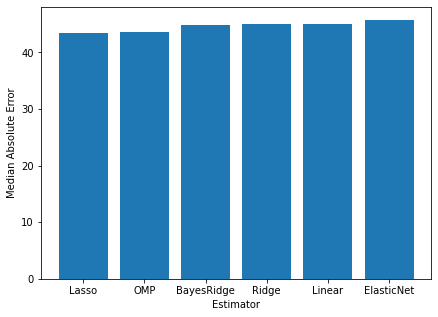

In [79]:
ests = [ linear_model.LinearRegression(), linear_model.Ridge(),
        linear_model.Lasso(), linear_model.ElasticNet(),
        linear_model.BayesianRidge(), linear_model.OrthogonalMatchingPursuit() ]
ests_labels = np.array(['Linear', 'Ridge', 'Lasso', 'ElasticNet', 'BayesRidge', 'OMP'])
errvals = np.array([])

X_train, X_test, y_train, y_test = train_test_split(df.drop(['price'], axis=1),
                                                    df.price, test_size=0.2, random_state=20)

for model in ests:
    model.fit(X_train, y_train)
    this_err = metrics.median_absolute_error(y_test, model.predict(X_test))
    errvals = np.append(errvals, this_err)

pos = np.arange(errvals.shape[0])
srt = np.argsort(errvals)
plt.figure(figsize=(7,5))
plt.bar(pos, errvals[srt], align='center')
plt.xticks(pos, ests_labels[srt])
plt.xlabel('Estimator')
plt.ylabel('Median Absolute Error')

Virheet ovat melko suuria, eikä oikeastaan mikään malleista häikäise. Datassa on todennäköisesti edelleen ns. outliereita, mutta toisaalta tämän metodin pitäisi toimia paremmin mahdollisten outliereiden suhteen. Katostaan, saadaanko monimuuttujamenetelmällä parempia tuloksia.

In [38]:
n_est = 600

tuned_parameters = {
    "n_estimators": [ n_est ],
    "max_depth" : [ 4 ],
    "learning_rate": [ 0.01 ],
    "loss" : [ 'squared_error', 'absolute_error' ]
}

gbr = ensemble.GradientBoostingRegressor()
clf = GridSearchCV(gbr, cv=3, param_grid=tuned_parameters,
        scoring='neg_median_absolute_error')
preds = clf.fit(X_train, y_train)
best = clf.best_estimator_
best

GradientBoostingRegressor(learning_rate=0.01, loss='absolute_error',
                          max_depth=4, n_estimators=600)

Katsotaan myös parhaan mallin tuottama keskivirhe

In [39]:
abs(clf.best_score_)

20.438373082506633

Kuten huomataan, virhe putosi alle puoleen monimuuttujamenetelmällä. Piirretään seuraavaksi virhe iteraatioiden funktiona, jotta voidaan arvioida, olisiko suuremmasta iteraatiomäärästä odotettavissa vielä hyötyä.

Text(0, 0.5, 'Least Absolute Deviation')

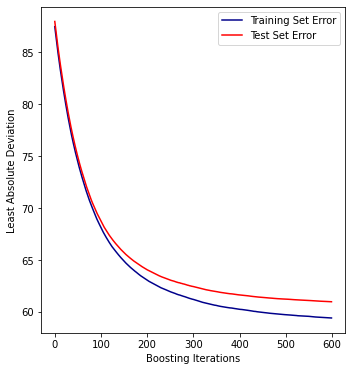

In [40]:
test_score = np.zeros(n_est, dtype=np.float64)

train_score = best.train_score_
for i, y_pred in enumerate(best.staged_predict(X_test)):
    test_score[i] = best.loss_(y_test, y_pred)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(np.arange(n_est), train_score, 'darkblue', label='Training Set Error')
plt.plot(np.arange(n_est), test_score, 'red', label='Test Set Error')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Least Absolute Deviation')

Käyrä alkaa tasoittua lähellä 600:aa, joten iteraatioiden kasvattaminen ei välttämättä tuota enää kovin suurta hyötyä. katsotaan seuraavaksi, kuinka hyvin eri muuttujat ennustivat vuokra-asunnon hintaa.

Text(0.5, 1.0, 'Variable Importance')

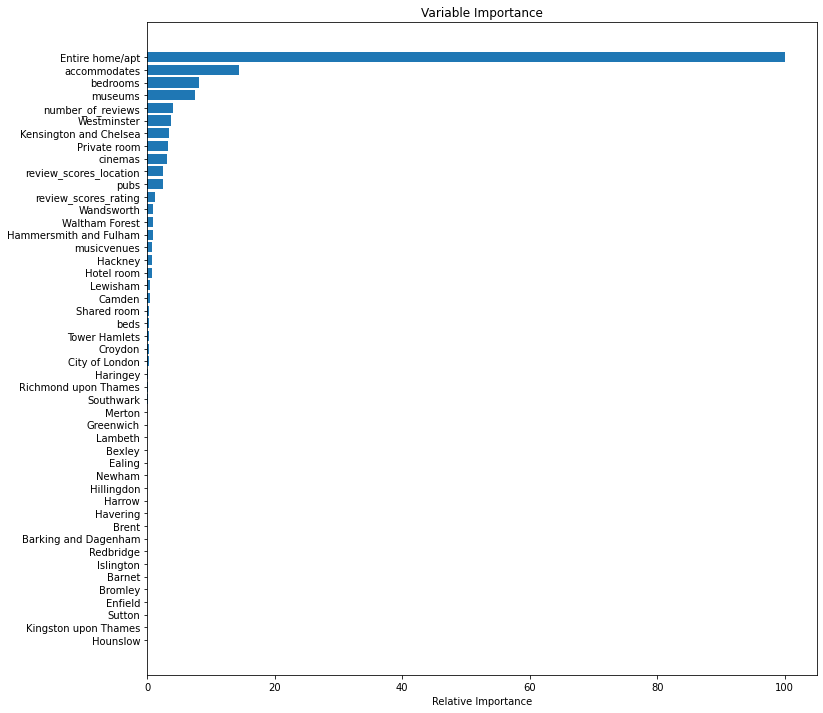

In [44]:
feature_importance = clf.best_estimator_.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
pvals = feature_importance[sorted_idx]
pcols = X_train.columns[sorted_idx]
plt.figure(figsize=(12,12))
plt.barh(pos, pvals, align='center')
plt.yticks(pos, pcols)
plt.xlabel('Relative Importance')
plt.title('Variable Importance')

Kuten huomataan, on muuttujien välillä suuria eroja siinä, miten hyvin ne ennustavat asunnon hintaa. Hinnassa suurin merkitys on sillä, onko koko asunto vuokraajan käytössä, vai jaetaanko se muiden kanssa. Myös sänkyjen ja makuuhuoneiden määrällä on merkitystä tämän analyysin perusteella, mutta data saattaa sisältää näiden osalta vielä asuntoja, jotka ovat ns. poikkeusyksilöitä. Etäisyyksistä eniten vaikuttaa merkitsevän etäisyys museoihin, vähiten taas konserttipaikkoihin. Esimerkiksi pubien osalta vaikutusta pienentävästi vaikuttaa todennäköisesti se, että pubeja on niin tasaisesti ympäri Lontoota, ettei ero etäisyydessä lähimpään pubiin ole alueiden välillä kovin suuri. Toisaalta data ei ota kantaa siihen, miten suosittuja mitkään lähimmistä kohteista ovat, sillä dataseteissä ei tätä tietoa ollut. Paikkojen suosion sisällyttämisen mahdollisuus olisi todennäköisesti vaikuttanut tuloksiin.

Lähdetään seuraavaksi tutkimaan asuinalueen ja etäisyyksien vaikutusta vuokrakohteen sijainnin saamaan arvosteluun. Lähdetään jälleen liikkeelle samoilla lineaarisilla malleilla joita esimerkissä käytettiin. Huomiona se, että pudotan myös arvostelujen lukumäärän sisältävän kolumnin pois opetus- ja testidataseteistä.

In [50]:
drop_cols = ['Unnamed: 0',
             'latitude',
             'longitude',
             'neighbourhood_cleansed',
             'room_type',
             'accommodates',
             'beds',
             'bedrooms',
             'price',
             'review_scores_rating',
             'Entire home/apt',
             'Hotel room',
             'Private room',
             'Shared room'
            ]

location_df = pd.read_csv('data.csv')
location_df = location_df.drop(drop_cols, axis=1)

/home/mauri_k_leino/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_base.py:133: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), OrthogonalMatchingPursuit())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(


Text(0, 0.5, 'Median Absolute Error')

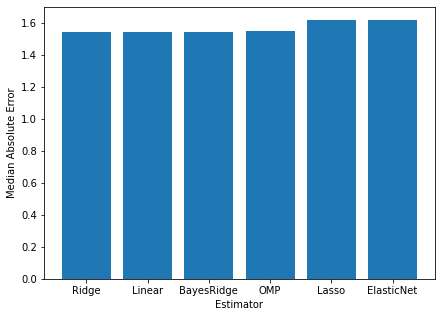

In [67]:
ests = [ linear_model.LinearRegression(), linear_model.Ridge(),
        linear_model.Lasso(), linear_model.ElasticNet(),
        linear_model.BayesianRidge(), linear_model.OrthogonalMatchingPursuit() ]
ests_labels = np.array(['Linear', 'Ridge', 'Lasso', 'ElasticNet', 'BayesRidge', 'OMP'])
errvals = np.array([])

X_train, X_test, y_train, y_test = train_test_split(location_df.drop(['review_scores_location', 'number_of_reviews'], axis=1),
                                                    location_df.review_scores_location, test_size=0.2, random_state=20)

for model in ests:
    model.fit(X_train, y_train)
    this_err = metrics.median_absolute_error(y_test, model.predict(X_test))
    errvals = np.append(errvals, this_err)

pos = np.arange(errvals.shape[0])
srt = np.argsort(errvals)
plt.figure(figsize=(7,5))
plt.bar(pos, errvals[srt], align='center')
plt.xticks(pos, ests_labels[srt])
plt.xlabel('Estimator')
plt.ylabel('Median Absolute Error')

Jälleen saamme melko suuria virheitä kaikilla menetelmillä. Tarkastellaan sitä, kuinka paljon nolla arvostelua saaneita kohteita datassa esiintyy, näiden kaikkien saamiksi arvosteluiksi on siis merkitty nolla.

In [68]:
(location_df['number_of_reviews'].values == 0.0).sum()

15812

Näitä rivejä on siis todella suuri osa datasta. Katostaan mihin tuloksiin päästään, kun nämä rivit otetaan datasta pois.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43417 entries, 0 to 59144
Data columns (total 39 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   number_of_reviews       43417 non-null  float64
 1   review_scores_location  43417 non-null  float64
 2   Barking and Dagenham    43417 non-null  int64  
 3   Barnet                  43417 non-null  int64  
 4   Bexley                  43417 non-null  int64  
 5   Brent                   43417 non-null  int64  
 6   Bromley                 43417 non-null  int64  
 7   Camden                  43417 non-null  int64  
 8   City of London          43417 non-null  int64  
 9   Croydon                 43417 non-null  int64  
 10  Ealing                  43417 non-null  int64  
 11  Enfield                 43417 non-null  int64  
 12  Greenwich               43417 non-null  int64  
 13  Hackney                 43417 non-null  int64  
 14  Hammersmith and Fulham  43417 non-null

/home/mauri_k_leino/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_base.py:133: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), OrthogonalMatchingPursuit())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(


Text(0, 0.5, 'Median Absolute Error')

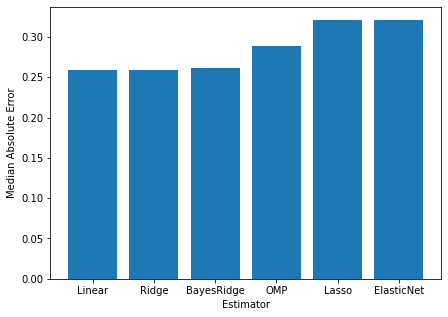

In [69]:
new_location_df = location_df[location_df['number_of_reviews'] != 0.0]

print(new_location_df.info())

ests = [ linear_model.LinearRegression(), linear_model.Ridge(),
        linear_model.Lasso(), linear_model.ElasticNet(),
        linear_model.BayesianRidge(), linear_model.OrthogonalMatchingPursuit() ]
ests_labels = np.array(['Linear', 'Ridge', 'Lasso', 'ElasticNet', 'BayesRidge', 'OMP'])
errvals = np.array([])

X_train, X_test, y_train, y_test = train_test_split(new_location_df.drop(['review_scores_location', 'number_of_reviews'], axis=1),
                                                    new_location_df.review_scores_location, test_size=0.2, random_state=20)

for model in ests:
    model.fit(X_train, y_train)
    this_err = metrics.median_absolute_error(y_test, model.predict(X_test))
    errvals = np.append(errvals, this_err)

pos = np.arange(errvals.shape[0])
srt = np.argsort(errvals)
plt.figure(figsize=(7,5))
plt.bar(pos, errvals[srt], align='center')
plt.xticks(pos, ests_labels[srt])
plt.xlabel('Estimator')
plt.ylabel('Median Absolute Error')

Virheet putosivat dramaattisesti. Datasettiin jäi nollarivien poiston jälkeenkin hyvä määrä dataa, ja nyt ilman arvosteluja olevat kohteet eivät ole sotkemassa. Tämä on seikka, joka olisi varmasti ollut hyvä ottaa huomioon jo datan jalostuvaiheessa ja asettaa arvostelemattomien kohteiden arvioiksi esimerkiksi koko datasetin keskiarvo, tai kohteen asuinalueen keskiarvo. Tehdään tällä datasetillä vielä monimuuttujaregressio ja etsitään sijainnin arvosteluun eniten vaikuttavia tekijöitä.

In [70]:
n_est = 600

tuned_parameters = {
    "n_estimators": [ n_est ],
    "max_depth" : [ 4 ],
    "learning_rate": [ 0.01 ],
    "loss" : [ 'squared_error', 'absolute_error' ]
}

gbr = ensemble.GradientBoostingRegressor()
clf = GridSearchCV(gbr, cv=3, param_grid=tuned_parameters,
        scoring='neg_median_absolute_error')
preds = clf.fit(X_train, y_train)
best = clf.best_estimator_
best

GradientBoostingRegressor(learning_rate=0.01, loss='absolute_error',
                          max_depth=4, n_estimators=600)

In [71]:
abs(clf.best_score_)

0.13341916021440894

Nyt päästiin jo todella pieneen virheeseen. Katsotaan vielä mallin kehitystä iteraatioiden funuktiona.

Text(0, 0.5, 'Least Absolute Deviation')

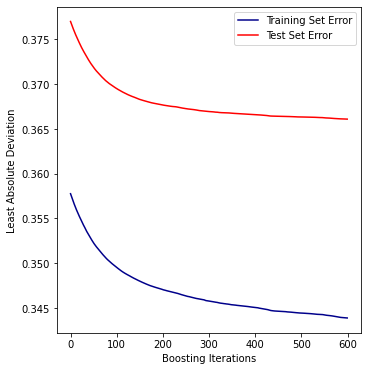

In [72]:
test_score = np.zeros(n_est, dtype=np.float64)

train_score = best.train_score_
for i, y_pred in enumerate(best.staged_predict(X_test)):
    test_score[i] = best.loss_(y_test, y_pred)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(np.arange(n_est), train_score, 'darkblue', label='Training Set Error')
plt.plot(np.arange(n_est), test_score, 'red', label='Test Set Error')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Least Absolute Deviation')

Malli alkaa suoriutua hyvin jo noin 400 iteraation kohdalla, ja sen jälkeen parannukset ovat yksikköinä erittäin minimaalisia. Katostaan vielä eri muuttujien vaikutus sijainnin arvosteluun.

Text(0.5, 1.0, 'Variable Importance')

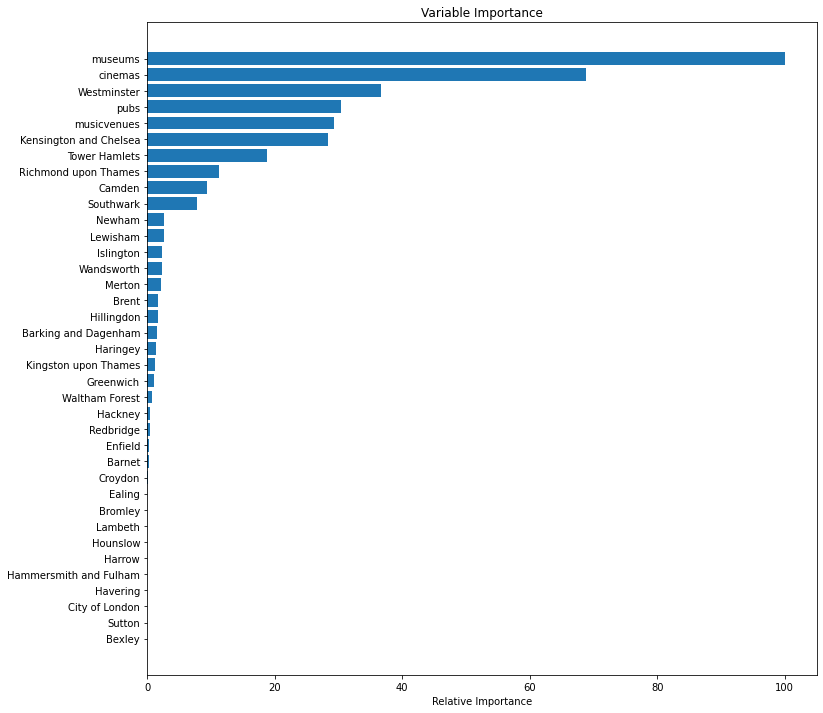

In [73]:
feature_importance = clf.best_estimator_.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
pvals = feature_importance[sorted_idx]
pcols = X_train.columns[sorted_idx]
plt.figure(figsize=(12,12))
plt.barh(pos, pvals, align='center')
plt.yticks(pos, pcols)
plt.xlabel('Relative Importance')
plt.title('Variable Importance')

Hieman yllättäen museoiden ja elokuvateattereiden läheisyydellä näyttäisi olevan suurin vaikutus sijainnin arvioon. Asuinalueista Westminsterillä on suurin vaikutus, mutta tämä analyysi ei tosin kerro onko vaikutus positiivinen vai negatiivinen. Pubien ja konserttipaikkojen vaikutukset ovat keskenään hyvin samaa luokkaa.

## Mietteitä ja linkkejä

<ul>
    <li>Airbnb-esimerkillä pääsi hyvin pitkälle, ja sitä pystyi soveltamaan myös sijainnin arvioiden ennustamiseen omassa käyttötapauksessani. Airbnb-esimerkki: <a href="https://github.com/InfoTUNI/joda2022/blob/master/koodiesimerkit/airnbn/python_scikit_airbnb.ipynb" target="_blank">https://github.com/InfoTUNI/joda2022/blob/master/koodiesimerkit/airnbn/python_scikit_airbnb.ipynb</a>
    <li>Scikit-kirjaston käyttö oli yksinkertaista, ja scikitin dokumentaatio on erittäin laadukas. Scikit-learn: <a href="https://scikit-learn.org/stable/user_guide.html" target="_blank">https://scikit-learn.org/stable/user_guide.html</a>
    <li>Pilviympäristö helpottaa tekemistä siinä mielessä, että laskennan voi jättää pyörimään taustalle sen vaikuttamatta oman koneeni suorituskykyyn. Tämä oli erittäin hyödyllistä GridSearchCV:tä käyttäessäni, sillä suuren datasetin ja useiden iteraatioiden vuoksi laskenta vei aikaa. Yritin vielä esimerkin mukaan ottaa käyttöön spark-sklearn-integraatiota, mutta tämä on nykyään vanhentunut, joskin tilalle on tarjolla joblib-spark-paketti. En kuitenkaan lähtenyt säätämään enää sen kanssa, vaan päätin antaa virtuaalikoneen tehdä hommat siinä ajassa mitä se tarvitsee. Joblib-sparkin dokumentaatio löytyy kuitenkin halukkaille täältä: <a href="https://github.com/joblib/joblib-spark" target="_blank">https://github.com/joblib/joblib-spark</a>
</ul>